In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import cross_validation
import tensorflow as tf
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import seaborn as sns
from bokeh.plotting import figure, output_file,show
from bokeh.palettes import d3
from bokeh.io import output_notebook
from bokeh.models import Legend
output_notebook()

Loading BokehJS ...

In [83]:
wine_red_df = pd.read_csv("data/winequality-red.csv", sep = ";")
wine_white_df = pd.read_csv("data/winequality-white.csv", sep = ";")
wine_red_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [84]:
wine_white_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [85]:
def custom_style(title, xlab, ylab, width = 800, height = 600):
    p = figure(plot_width = width, plot_height = height, title = title, x_axis_label = xlab, y_axis_label = ylab)
    p.title.text_font_size = "10pt"
    p.title.align = "center"
    p.xaxis.axis_label_text_font_size = "10pt"
    p.yaxis.axis_label_text_font_size = "10pt"
    return p

def custom_barplot(data, width = 400, height = 400, color = "#3687cc", title = "Barplot", xlab = "Category",
                   ylab = "Counts"):
    counts = data.value_counts()
    p = custom_style(width = width, height = height, title = title, xlab = xlab, ylab = ylab)
    p.vbar(x = counts.index, top = counts.values, width = 0.5, bottom = 0,  color = color)
    return show(p)

In [86]:
custom_barplot(wine_red_df.quality, title = "Red Wine Quality", xlab = "Quality Level of wine (0 to 10 scale)", 
               ylab = "Counts")

In [87]:
custom_barplot(wine_white_df.quality, title = "White Wine Quality", xlab = "Quality Level of wine (0 to 10 scale)", 
               ylab = "Counts")

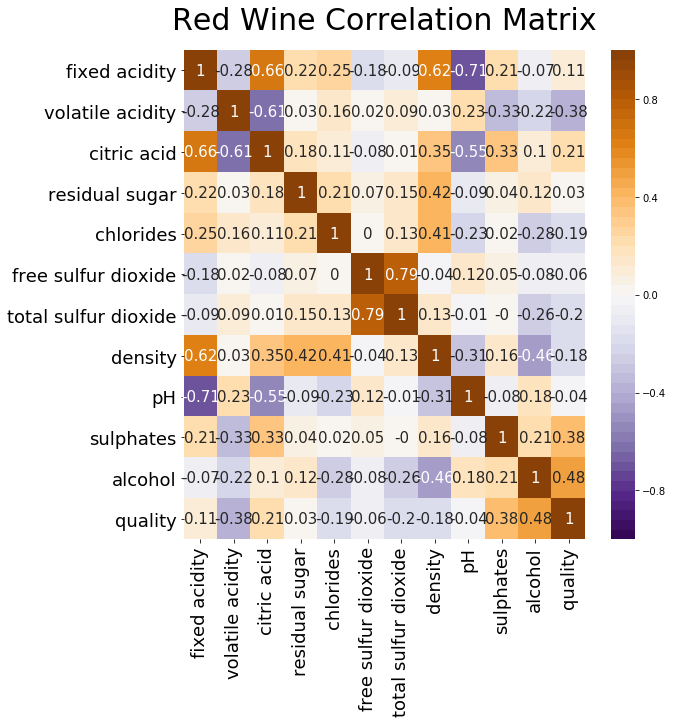

In [88]:
def confusion_matrix_plot(data, title = "Red Wine Correlation Matrix", height = 9, width = 9):
    conf_mat = round(data.corr(method ="spearman"), 2)
    plt.figure(figsize = (width, height))
    ax = sns.heatmap(conf_mat, annot=True, annot_kws={"size": 15}, cmap = sns.color_palette("PuOr_r", 50), 
                     vmin = -1, vmax = 1)
    ax.axes.set_title(title, fontsize = 30)
    ax.title.set_position([.5, 1.03])
    ax.set_xticklabels(labels = conf_mat.index, fontsize = 18)
    ax.set_yticklabels(labels = conf_mat.index, fontsize = 18)
    plt.show()
    
confusion_matrix_plot(wine_red_df, title = "Red Wine Correlation Matrix")

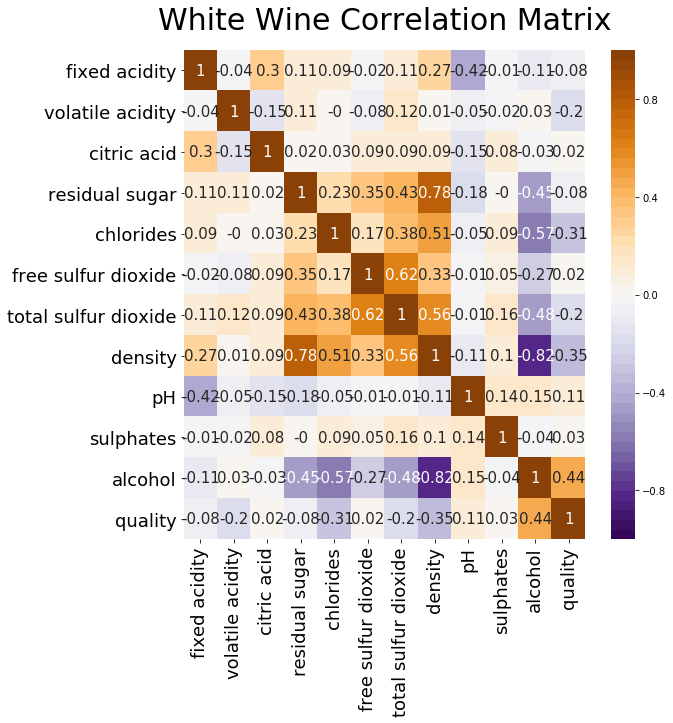

In [89]:
confusion_matrix_plot(wine_white_df, title = "White Wine Correlation Matrix")

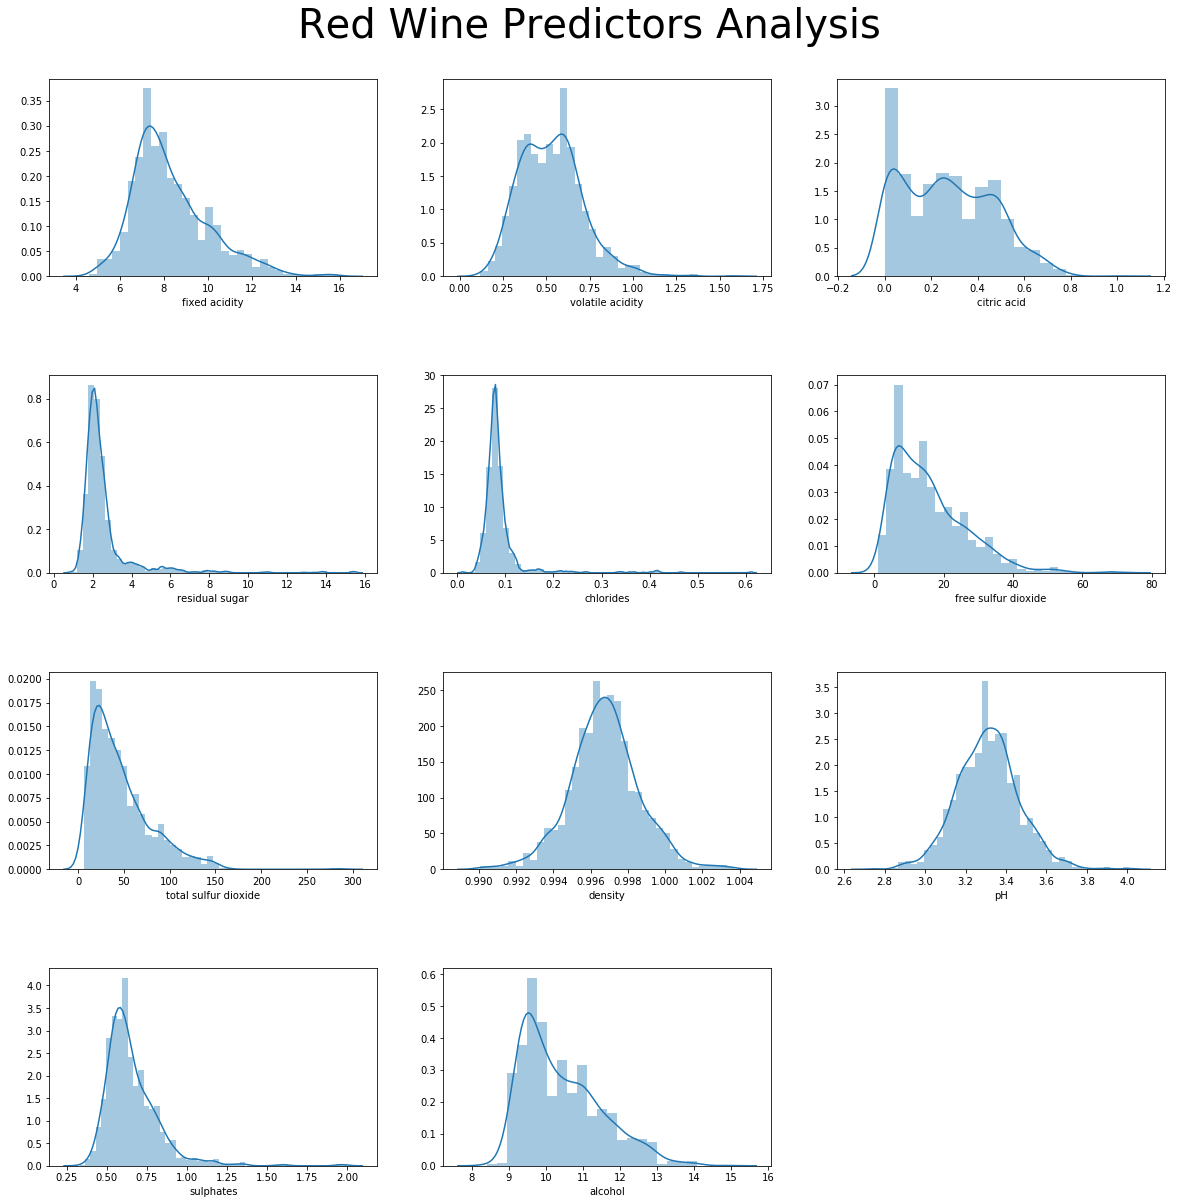

In [90]:
data = wine_red_df.iloc[:,:-1]
row = 4 
column = 3
width = 20
height = 20
title = "Red Wine Predictors Analysis"
fig = plt.figure(figsize = (width, height))
fig.suptitle(title, fontsize=40, y = 0.93)
for i in range(data.shape[1]):
    ax = fig.add_subplot(row, column, i + 1)
    fig.subplots_adjust(hspace = .5)
    sns.distplot(wine_red_df.iloc[:, i], ax=ax)
        
plt.show()
    


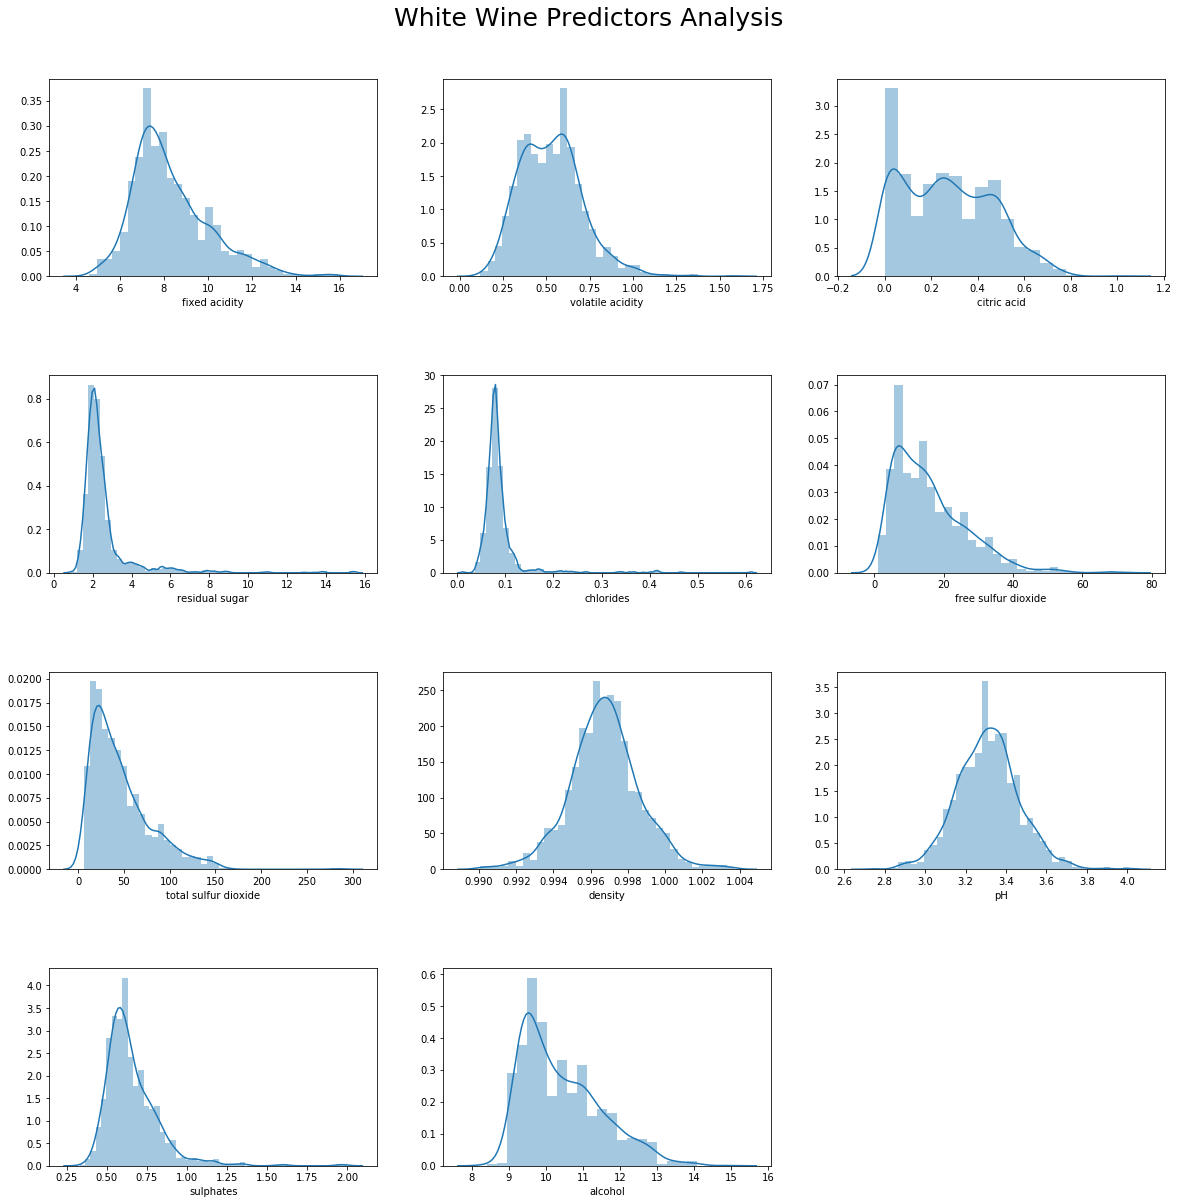

In [91]:
data = wine_white_df.iloc[:,:-1]
row = 4 
column = 3
width = 20
height = 20
title = "White Wine Predictors Analysis"
fig = plt.figure(figsize = (width, height))
fig.suptitle(title, fontsize=25, y = 0.93)
for i in range(data.shape[1]):
    ax = fig.add_subplot(row, column, i + 1)
    fig.subplots_adjust(hspace = .5)
    sns.distplot(wine_red_df.iloc[:, i], ax=ax)
        
plt.show()
    


In [92]:
wine_red_df[["citric acid"]] += 0.1
wine_white_df[["citric acid"]] += 0.1

In [93]:
#performing boxcox transformation to reduce skewness
def boxcox_trans(data):
    for i in range(data.shape[1]):
        data.iloc[:, i], _ = st.boxcox(data.iloc[:, i])
    return data

red_trans = wine_red_df.copy(deep = True)
red_trans.iloc[:, :-1] = boxcox_trans(red_trans.iloc[:, :-1])
white_trans = wine_white_df.copy(deep = True)
white_trans.iloc[:, :-1] = boxcox_trans(white_trans.iloc[:, :-1])

In [94]:
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(wine_red_df.iloc[:, :-1], wine_red_df.iloc[:, -1],
                                                    test_size=0.25, random_state=1)
X_train_white, X_test_white, y_train_white, y_test_white = train_test_split(wine_white_df.iloc[:, :-1], wine_white_df.iloc[:, -1],
                                                    test_size=0.25, random_state=1)

In [95]:
best_score = 0
best_C = 10000
C_list = [0.01,0.1,1, 10, 100, 1000]
for C in C_list:
    svc = svm.SVC(C = C, kernel = 'rbf')
    scores = cross_val_score(svc, X_train_red, y_train_red, cv = 10)
    score = scores.mean()
    if score > best_score:
        best_C = C
        best_score = score
svc = svm.SVC(C = best_C, kernel = "rbf")
svc.fit(X_train_red, y_train_red)
accuracy = svc.score(X_test_red, y_test_red)
accuracy

0.5775

In [96]:
best_score = 0
best_C = 10000
C_list = [0.01,0.1,1, 10, 100, 1000]
for C in C_list:
    svc = svm.SVC(C = C, kernel = 'rbf')
    scores = cross_val_score(svc, X_train_white, y_train_white, cv = 10)
    score = scores.mean()
    if score > best_score:
        best_C = C
        best_score = score
svc = svm.SVC(C = best_C, kernel = "rbf")
svc.fit(X_train_white, y_train_white)
accuracy = svc.score(X_test_white, y_test_white)
accuracy

0.5755102040816327

In [97]:
from sklearn.ensemble import RandomForestClassifier

In [98]:
alg1 = RandomForestClassifier(n_estimators = 100)
alg1.fit(X_train_red,y_train_red)
alg1.score(X_test_red,y_test_red)

0.6825

In [99]:
alg1.fit(X_train_white,y_train_white)
alg1.score(X_test_white,y_test_white)

0.6751020408163265

In [100]:
from sklearn.neighbors import KNeighborsClassifier


In [101]:
alg2 = KNeighborsClassifier()
alg2.fit(X_train_red,y_train_red)
alg2.score(X_test_red,y_test_red)

0.515

In [102]:
alg2.fit(X_train_white,y_train_white)
alg2.score(X_test_white,y_test_white)

0.4751020408163265

Classifying wine in 2 categories (red and white)

In [103]:
red_trans["wine type"] = 0
white_trans["wine type"] = 1
wine_df = pd.concat([red_trans, white_trans], axis = 0, ignore_index = False)

X_train, X_test, y_train, y_test = train_test_split(wine_df.iloc[:, :-1], wine_df.iloc[:, -1],
                                                    test_size=0.25, random_state=1)
best_score = 0
best_C = 10000
C_list = [0.01,0.1,1, 10, 100, 1000]
for C in C_list:
    svc = svm.SVC(C = C, kernel = 'rbf')
    scores = cross_val_score(svc, X_train, y_train, cv = 10)
    score = scores.mean()
    if score > best_score:
        best_C = C
        best_score = score
svc = svm.SVC(C = best_C, kernel = "rbf")
svc.fit(X_train, y_train)
accuracy = svc.score(X_test, y_test)
accuracy

1.0